<a href="https://colab.research.google.com/github/PaloMoshoeshoe/Stroke-prediction/blob/main/Stroke.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Brain Stroke Prediction: Evaluation of the performances of surrogate models to Black-Box Machine Learning model on Binary classification data ***
1. This is a medical condition where insufficient blood flow to the brain kill brain cells.

Dataset (Type: Binary Classification)
The dataset is sourced from https://www.kaggle.com/datasets/zzettrkalpakbal/full-filled-brain-stroke-dataset?datasetId=2343381&sortBy=voteCount

**The stroke disease overview:**



In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score,recall_score, classification_report, precision_recall_curve, f1_score, accuracy_score, roc_curve, roc_auc_score, auc
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTE

from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.backend import dropout
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.metrics import Precision, Recall, AUC

In [ ]:
#importing the dataset
df = pd.read_csv('stroke.csv')
df

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
2,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
3,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
4,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1
...,...,...,...,...,...,...,...,...,...,...,...
4976,Male,41.0,0,0,No,Private,Rural,70.15,29.8,formerly smoked,0
4977,Male,40.0,0,0,Yes,Private,Urban,191.15,31.1,smokes,0
4978,Female,45.0,1,0,Yes,Govt_job,Rural,95.02,31.8,smokes,0
4979,Male,40.0,0,0,Yes,Private,Rural,83.94,30.0,smokes,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4981 entries, 0 to 4980
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             4981 non-null   object 
 1   age                4981 non-null   float64
 2   hypertension       4981 non-null   int64  
 3   heart_disease      4981 non-null   int64  
 4   ever_married       4981 non-null   object 
 5   work_type          4981 non-null   object 
 6   Residence_type     4981 non-null   object 
 7   avg_glucose_level  4981 non-null   float64
 8   bmi                4981 non-null   float64
 9   smoking_status     4981 non-null   object 
 10  stroke             4981 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 428.2+ KB


# **Explratory Data Analysis**

In [ ]:
df.describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,4981.000000,4981.000000,4981.000000,4981.000000,4981.000000,4981.000000
mean,43.419859,0.096165,0.055210,105.943562,28.498173,0.049789
std,22.662755,0.294848,0.228412,45.075373,6.790464,0.217531
min,0.080000,0.000000,0.000000,55.120000,14.000000,0.000000
25%,25.000000,0.000000,0.000000,77.230000,23.700000,0.000000
50%,45.000000,0.000000,0.000000,91.850000,28.100000,0.000000
75%,61.000000,0.000000,0.000000,113.860000,32.600000,0.000000
max,82.000000,1.000000,1.000000,271.740000,48.900000,1.000000


In [ ]:
#Identifying categorical features
categorical_features = [feature for feature in df.columns if df[feature].dtypes == 'O']
categorical_features

['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']

In [ ]:
#Identify unique feature for each category
for feature in categorical_features:
    print(f'{feature}: {df[feature].unique()}')

gender: ['Male' 'Female']
ever_married: ['Yes' 'No']
work_type: ['Private' 'Self-employed' 'Govt_job' 'children']
Residence_type: ['Urban' 'Rural']
smoking_status: ['formerly smoked' 'never smoked' 'smokes' 'Unknown']


In [ ]:
# Encoding categorical features
df['gender'] = df['gender'].replace({'Female':0, 'Male':1, 'Other':2})
df['ever_married'] = df['ever_married'].replace({'No':0, 'Yes':1})
df['work_type'] = df['work_type'].replace({'Private':0, 'Self-employed':1, 'children':2, 'Govt_job':3, 'Never_worked':4})
df['Residence_type'] = df['Residence_type'].replace({'Urban':0, 'Rural':1})
df['smoking_status'] = df['smoking_status'].replace({'never smoked':0, 'Unknown':1, 'formerly smoked':2, 'smokes':3})


/tmp/ipython-input-1415767704.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['gender'] = df['gender'].replace({'Female':0, 'Male':1, 'Other':2})
/tmp/ipython-input-1415767704.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['ever_married'] = df['ever_married'].replace({'No':0, 'Yes':1})
/tmp/ipython-input-1415767704.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to t

In [ ]:
#remove NaN values
df = df.dropna()

In [ ]:
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,1,67.0,0,1,1,0,0,228.69,36.6,2,1
1,1,80.0,0,1,1,0,1,105.92,32.5,0,1
2,0,49.0,0,0,1,0,0,171.23,34.4,3,1
3,0,79.0,1,0,1,1,1,174.12,24.0,0,1
4,1,81.0,0,0,1,0,0,186.21,29.0,2,1


In [ ]:
df.shape

(4981, 11)

In [ ]:
df = df.dropna()

<Axes: >

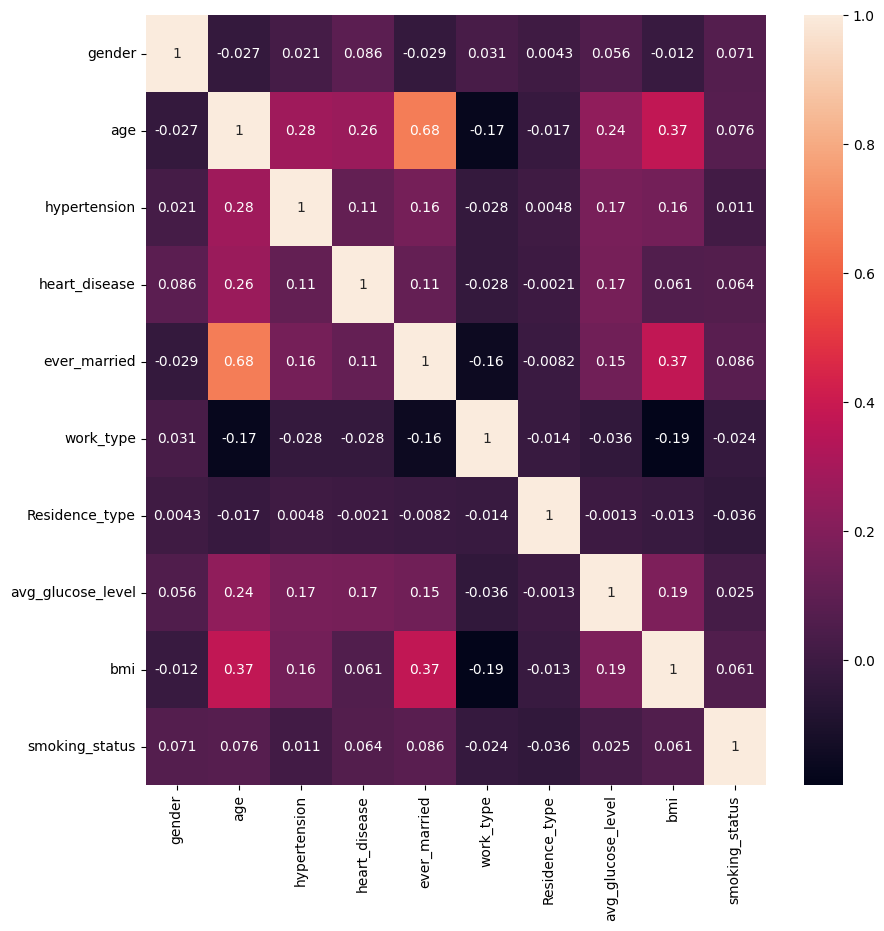

In [ ]:
#Correlation between features and brain stroke
plt.figure(figsize = (10, 10))
sns.heatmap(df.drop(['stroke'], axis = 1).corr(), annot = True)

Text(0.5, 1.0, 'Age/stroke distribution')

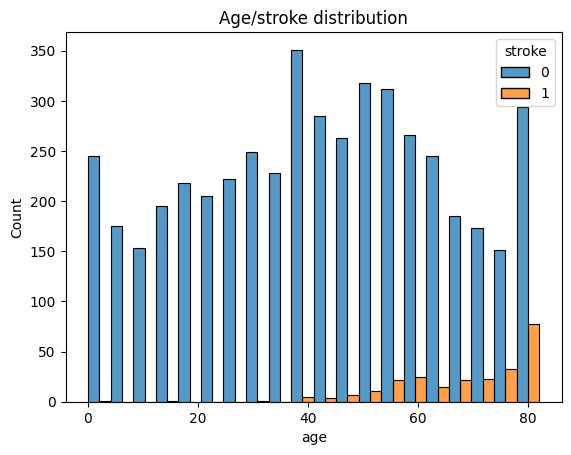

In [ ]:

# Visualize the age of people with stroke versus people without stroke
sns.histplot(
    data=df,
    x="age",
    hue="stroke",
    multiple="dodge"
).set_title("Age/stroke distribution")

stroke
0    4733
1     248
Name: count, dtype: int64


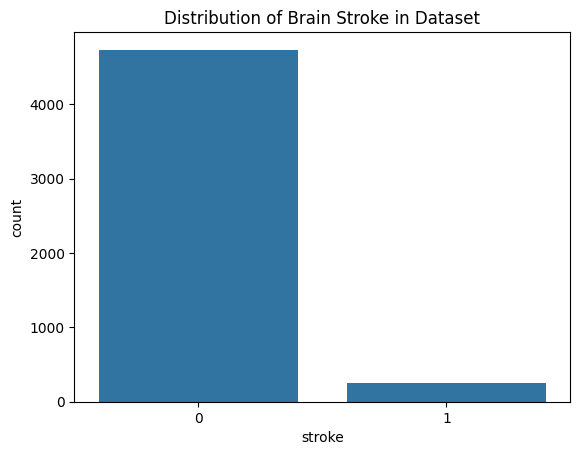

In [ ]:
#Check data imbalance
sns.countplot(x='stroke', data=df)
plt.title('Distribution of Brain Stroke in Dataset')
category_counts = df['stroke'].value_counts()
print(category_counts)

SMOTE (Synthetic Minority Over-sampling Technique) SMOTE, or Synthetic Minority Over-sampling Technique, is a widely used oversampling method in machine learning designed to address class imbalance in datasets. Class imbalance occurs when one class (the minority class) has significantly fewer instances than another (the majority class), leading to biased models that perform poorly on the minority class. How SMOTE Works: SMOTE generates synthetic samples for the minority class, rather than simply duplicating existing instances. The process involves: Identifying Minority Class Instances: The algorithm focuses on the minority class examples. Finding Nearest Neighbors: For each minority class instance, SMOTE identifies its k-nearest neighbors within the minority class, typically using Euclidean distance. Generating Synthetic Samples: For each minority instance, SMOTE randomly selects one of its k-nearest neighbors. A new synthetic sample is then created by interpolating between the original minority instance and the selected neighbor. This interpolation involves taking a random step along the line segment connecting the two instances in the feature space. Purpose and Benefits: Balances Class Distribution: SMOTE increases the number of minority class samples, making the dataset more balanced and preventing models from being overly biased towards the majority class. Improves Model Performance: By providing more representative data for the minority class, SMOTE helps machine learning models learn the underlying patterns and decision boundaries more effectively, leading to improved performance, especially in terms of recall and F1-score for the minority class. Reduces Overfitting: Unlike simple oversampling (duplicating instances), SMOTE creates synthetic, yet distinct, samples, which can help reduce the risk of overfitting to the limited minority class data. Considerations: While effective, SMOTE has some limitations. It may not perform optimally in high-dimensional datasets or when the minority class instances are very sparse or noisy, as the interpolation might generate samples in regions where no real data exists. Variants like Borderline-SMOTE and ADASYN address some of these limitations by focusing on more challenging or difficult-to-classify minority instances.

Before balancing:
stroke
0    3790
1     194
Name: count, dtype: int64


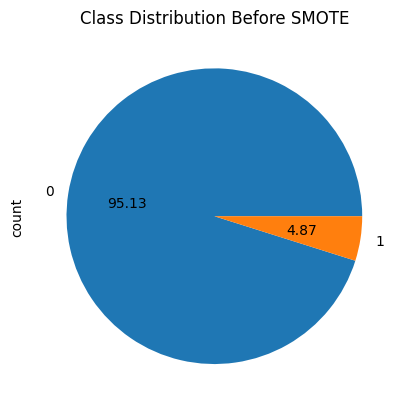


After balancing:
stroke
0    3790
1    3790
Name: count, dtype: int64


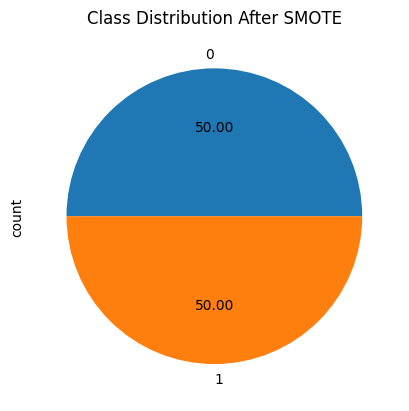

In [ ]:
# The data is imbalanced therefor it has to be balanced to reduce bias

# Define features (X) and target (y)
X = df.drop('stroke', axis=1)
y = df['stroke']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.80, random_state=42)

#(y_train.shape, y_test.shape)
# Balance the imbalance dataset using SMOTE
print('Before balancing:')
print(y_train.value_counts())
y_train.value_counts().plot.pie(autopct='%.2f')
plt.title('Class Distribution Before SMOTE')
plt.show()

smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

print('\nAfter balancing:')
print(y_train_sm.value_counts())
y_train_sm.value_counts().plot.pie(autopct='%.2f')
plt.title('Class Distribution After SMOTE')
plt.show()

# Looking for a black-box model that best predict out data by comparing Random Forest, XGBost and Neural Networks Models

# Random Forest
Another method we can use to make the random forest more sensitive to the minority class is to use under-/oversampling during the bootstrap sampling. Oversampling works by sampling more observation from the minority class by either duplicating or creating new synthetic observations, such that the occurrence of minority observations is more balanced compare with the majority class. Undersampling works by deleting or merging examples in the majority class.

The Python library imbalanced-learn offers a number of resampling techniques which can be used in datasets showing strong imbalance. It includes an implementation of the Balanced Random Forest methods, which works by randomly undersampling from the majority class during the bootstrap sampling:

In [ ]:

RF = RandomForestClassifier(n_estimators=100, random_state=42)
RF.fit(X_train_sm, y_train_sm)
y_pred_RF = RF.predict(X_test)
score_RF = accuracy_score(y_pred_RF,y_test)
fscore_RF = f1_score(y_pred_RF,y_test)
precision_RF = precision_score(y_pred_RF,y_test)
recall_RF = recall_score(y_pred_RF,y_test)
print('Results for RF Model')
print(f'Classification Report for Random Forest \n\n{classification_report(y_test, y_pred_RF)}')


Results for RF Model
Classification Report for Random Forest 

              precision    recall  f1-score   support

           0       0.95      0.94      0.94       943
           1       0.13      0.17      0.15        54

    accuracy                           0.89       997
   macro avg       0.54      0.55      0.55       997
weighted avg       0.91      0.89      0.90       997



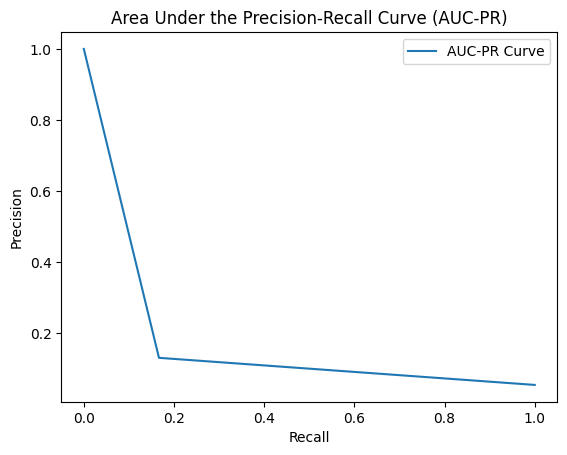

In [ ]:
# Plot AUC-PR curve
RF_precision, RF_recall, _ = precision_recall_curve(y_test, y_pred_RF)
plt.plot(RF_recall, RF_precision, label='AUC-PR Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Area Under the Precision-Recall Curve (AUC-PR)')
plt.legend()
plt.show()

In [ ]:
#keep the probabilities for the positive predictions
y_pred_RF = RF.predict_proba(X_test)[:, 1]

# Calculate the true positive rate (TPR), false positive rate (FPR)
RF_fpr, RF_tpr, thresholds = roc_curve(y_test, y_pred_RF)

# Calculate the AUC score
auc_RF = roc_auc_score(y_test, y_pred_RF)
print("ROC AUC score:", auc_RF)

ROC AUC score: 0.776687875574408


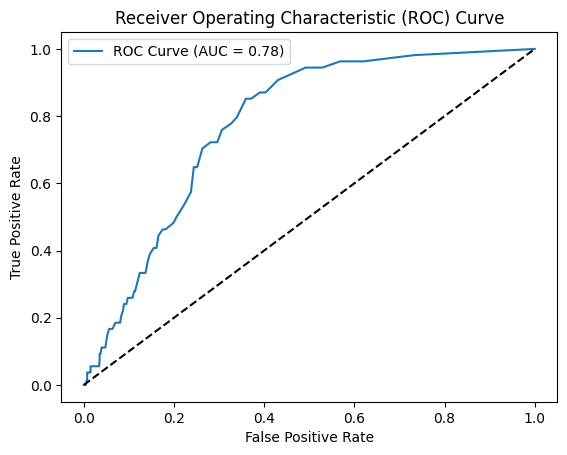

In [ ]:
# Plot the ROC curve
plt.plot(RF_fpr, RF_tpr, label='ROC Curve (AUC = {:.2f})'.format(auc_RF))
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random guessing
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

**XGBoost (Extreme Gradient Boosting)** Is an optimized implementation of the gradient boosting algorithm, which is a popular machine learning technique for regression and classification tasks. XGBoost combines multiple weak predictive models (typically decision trees) in an iterative manner to build a powerful ensemble model.

GridSearchCV is a method provided by scikit-learn that allows you to perform an exhaustive search over a specified parameter grid to find the best combination of hyperparameters for a machine learning model.

In [ ]:
# Define the parameter grid
param_grid = {
    'max_depth': [4, 6, 8, 10],
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': [50, 100, 200, 300]
}

# Create an instance of XGBClassifier
xgb_model = XGBClassifier(objective='binary:logistic', random_state = 42)

# Create GridSearchCV object
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='average_precision')

# Fit the data to perform the search
grid_search.fit(X_train_sm, y_train_sm)

# Access the best parameters and best score
print("Best parameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

Best parameters:  {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 300}
Best score:  0.990263291054695


In [ ]:
# Fit model based on the parameters that gaven from GridSearchCV
# Create an instance of XGBClassifier

XGB = XGBClassifier(objective='binary:logistic',
                              n_estimators=300,
                              max_depth=10,
                              learning_rate=0.1,
                              random_state=42)

# Fit the data to train the XGBoost model
XGB.fit(X_train_sm, y_train_sm)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=300,
              n_jobs=None, num_parallel_tree=None, ...)

In [ ]:
# Make predictions on the test data
y_pred_XGB = XGB.predict(X_test)
score_XGB = accuracy_score(y_pred_XGB,y_test)
fscore_XGB = f1_score(y_pred_XGB,y_test)
precision_XGB = precision_score(y_pred_XGB,y_test)
recall_XGB = recall_score(y_pred_XGB,y_test)
auc_XGB = roc_auc_score(y_test, y_pred_XGB)
print('Results for XGB Model')
print('ROC AUC : ',auc_XGB)
print(f'Classification Report for XGBoost \n\n{classification_report(y_test, y_pred_XGB)}')


Results for XGB Model
ROC AUC :  0.5618396763677782
Classification Report for XGBoost 

              precision    recall  f1-score   support

           0       0.95      0.94      0.95       943
           1       0.15      0.19      0.16        54

    accuracy                           0.90       997
   macro avg       0.55      0.56      0.55       997
weighted avg       0.91      0.90      0.90       997



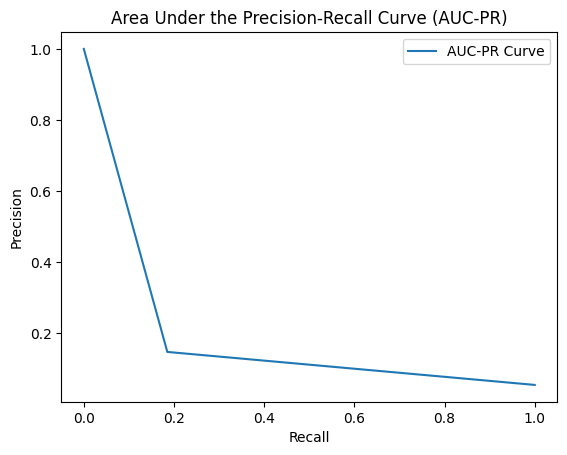

In [ ]:
# Plot AUC-PR curve
XGB_precision, XGB_recall, _ = precision_recall_curve(y_test, y_pred_XGB)
plt.plot(XGB_recall, XGB_precision, label='AUC-PR Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Area Under the Precision-Recall Curve (AUC-PR)')
plt.legend()
plt.show()

In [ ]:

# Calculate AUC-PR curve
auc_pr = auc(XGB_recall, XGB_precision)
print("AUC-PR:", auc_pr)

AUC-PR: 0.18818820295308583


In [ ]:
#keep the probabilities for the positive predictions
y_pred_XGB = XGB.predict_proba(X_test)[:, 1]

# Calculate the true positive rate (TPR), false positive rate (FPR)
XGB_fpr, XGB_tpr, thresholds = roc_curve(y_test, y_pred_XGB)

# Calculate the AUC score
auc_XGB = roc_auc_score(y_test, y_pred_XGB)
print("AUC score:", auc_XGB)

AUC score: 0.7512764620399828


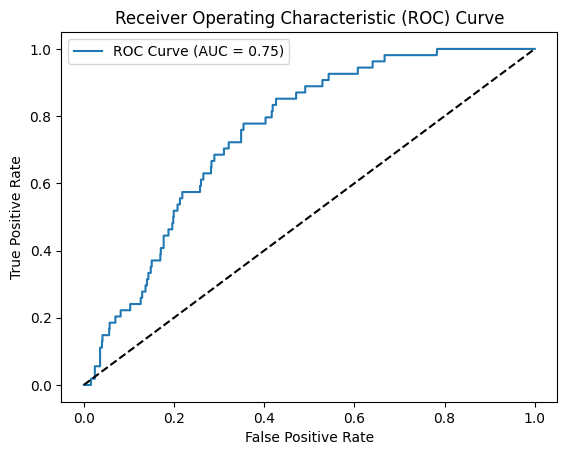

In [ ]:
# Plot the ROC curve
plt.plot(XGB_fpr, XGB_tpr, label='ROC Curve (AUC = {:.2f})'.format(auc_XGB))
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random guessing
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

# Neural Networks

The neural network model is defined using Keras. The model consists of three hidden layers with 400, 400 and 128 neurons respectively, and ReLU activation. Two dropouts are performed for avoiding overfitting. The output layer has a single neuron with sigmoid activation since we are performing binary classification (stroke or no stroke).

In [ ]:

# Normalize the features
scaler = StandardScaler()
X_train_norm = scaler.fit_transform(X_train_sm)
X_test_norm = scaler.transform(X_test)

In [ ]:

# Build the neural network model
deep_model = Sequential()
deep_model.add(Dense(400,activation='relu', input_shape=(X_train_norm.shape[1],)))
deep_model.add(Dropout(0.5))
deep_model.add(Dense(400,activation='relu'))
deep_model.add(Dropout(0.5))
deep_model.add(Dense(128,activation='relu'))
deep_model.add(Dense(1,activation='sigmoid'))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Create a compiler and train the model the model
deep_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy', Precision(), Recall(), AUC()])
deep_model.fit(X_train_norm, y_train_sm, epochs=10, batch_size=40, verbose=1)

Epoch 1/10
190/190 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.7681 - auc_2: 0.8467 - loss: 0.4763 - precision_2: 0.7572 - recall_2: 0.8108
Epoch 2/10
190/190 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8300 - auc_2: 0.9051 - loss: 0.3833 - precision_2: 0.8082 - recall_2: 0.8675
Epoch 3/10
190/190 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8392 - auc_2: 0.9192 - loss: 0.3547 - precision_2: 0.8247 - recall_2: 0.8577
Epoch 4/10
190/190 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8468 - auc_2: 0.9205 - loss: 0.3489 - precision_2: 0.8238 - recall_2: 0.8773
Epoch 5/10
190/190 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8522 - auc_2: 0.9265 - loss: 0.3387 - precision_2: 0.8322 - recall_2: 0.8781
Epoch 6/10
190/190 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8591 - auc_2: 0.9309 - loss: 0.3274 - precision_2: 0.8340 - recall_2: 0.8971
Epoch 7/10
190/190 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8545 - auc_2: 0.9321 - loss: 0.3225 - precision_2: 0.8338 - recall_2: 0.890

In [ ]:
# Predict using test dataset
y_pred_NN = deep_model.predict(X_test_norm)
y_pred_NN = (y_pred_NN > 0.5).astype(int)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [ ]:
score_NN = accuracy_score(y_test, y_pred_NN)
precision_NN = precision_score(y_test, y_pred_NN)
recall_NN = recall_score(y_test, y_pred_NN)
fscore_NN = f1_score(y_test, y_pred_NN)
auc_NN = roc_auc_score(y_test, y_pred_NN)
print('ROC AUC : ',auc_NN)
print(f'Classification Report \n\n{classification_report(y_test, y_pred_NN)}')

ROC AUC :  0.5847276226385452
Classification Report 

              precision    recall  f1-score   support

           0       0.96      0.82      0.88       943
           1       0.10      0.35      0.16        54

    accuracy                           0.79       997
   macro avg       0.53      0.58      0.52       997
weighted avg       0.91      0.79      0.84       997



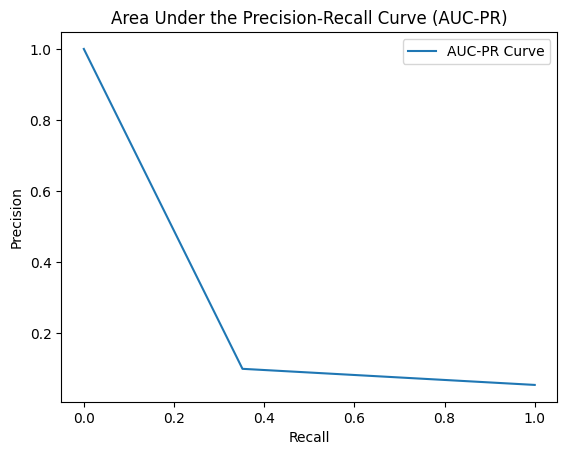

In [ ]:
# Plot AUC-PR curve
NN_precision, NN_recall, _ = precision_recall_curve(y_test, y_pred_NN)
plt.plot(NN_recall, NN_precision, label='AUC-PR Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Area Under the Precision-Recall Curve (AUC-PR)')
plt.legend()
plt.show()

In [ ]:
#keep the probabilities for the positive predictions
y_pred_NN_proba = deep_model.predict(X_test_norm)[:, 0]

# Calculate the true positive rate (TPR), false positive rate (FPR)
NN_fpr, NN_tpr, thresholds = roc_curve(y_test, y_pred_NN_proba)

# Calculate the AUC score
auc_NN = roc_auc_score(y_test, y_pred_NN_proba)
print("AUC score:", auc_NN)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
AUC score: 0.7219865676917638


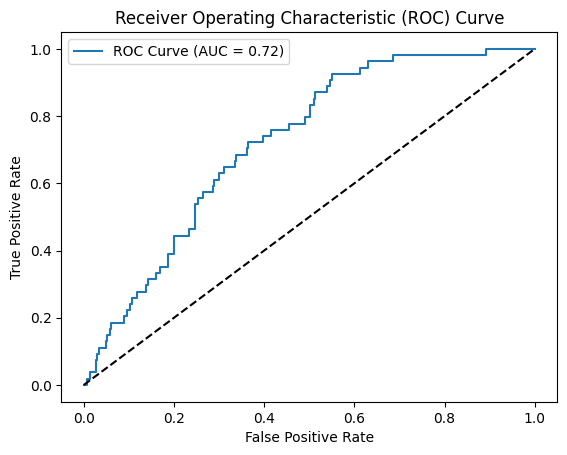

In [ ]:
# Plot the ROC curve
plt.plot(NN_fpr, NN_tpr, label='ROC Curve (AUC = {:.2f})'.format(auc_NN))
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random guessing
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

# Comparing the Black-box models

In [ ]:

auc = [auc_RF,auc_XGB,auc_NN]
scores = [score_RF,score_XGB,score_NN]
precision = [precision_RF,precision_XGB,precision_NN]
recall = [recall_RF,recall_XGB,recall_NN]
fscore = [fscore_RF,fscore_XGB,fscore_NN]
names = ["RF", "XGB", "NN"]
classification_results = pd.DataFrame({
    "Accuracy": scores,
    "Precision": precision,
    "Recall":recall,
    "F1 Score":fscore,
    "AUC":auc
})
classification_results.index = names
classification_results

,Accuracy,Precision,Recall,F1 Score,AUC
RF,0.894684,0.166667,0.130435,0.146341,0.776688
XGB,0.897693,0.185185,0.147059,0.163934,0.751276
NN,0.792377,0.099476,0.351852,0.155102,0.721987


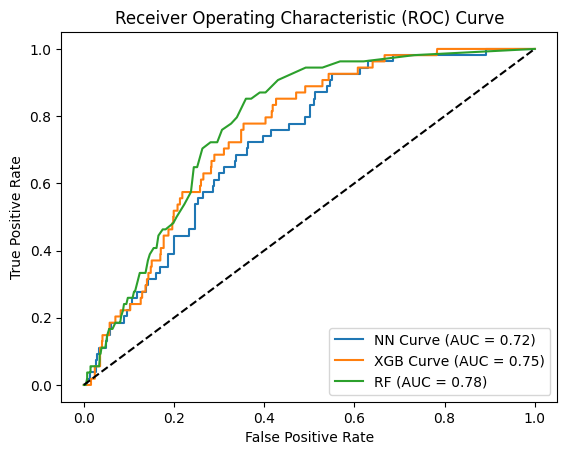

In [ ]:
# Plot the ROC curve
plt.plot(NN_fpr, NN_tpr, label='NN Curve (AUC = {:.2f})'.format(auc_NN))
plt.plot(XGB_fpr, XGB_tpr, label='XGB Curve (AUC = {:.2f})'.format(auc_XGB))
plt.plot(RF_fpr, RF_tpr, label='RF (AUC = {:.2f})'.format(auc_RF))
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random guessing
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

Text(0.5, 1.0, 'Final scaled output results for machine learning models')

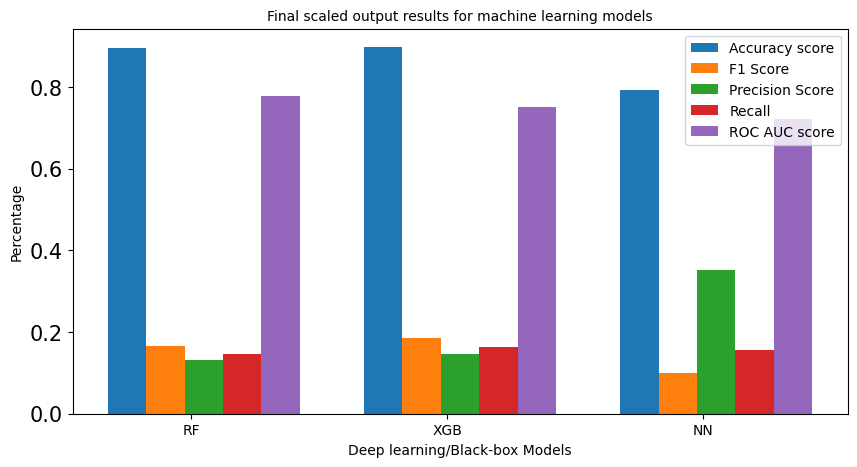

In [ ]:
algorithms = np.arange(len(names))
plt.figure(figsize = (10, 5))
plt.yticks(fontsize = 15)
plt.bar(algorithms, [i for i in scores], width = 0.15)
plt.bar(algorithms + 0.15, [i for i in precision], width = 0.15)
plt.bar(algorithms + 0.15 * 2, [i for i in recall], width = 0.15)
plt.bar(algorithms + 0.15 * 3, [i for i in fscore], width = 0.15)
plt.bar(algorithms + 0.15 * 4, [i for i in auc], width = 0.15)
plt.legend(['Accuracy score', 'F1 Score', 'Precision Score', 'Recall', 'ROC AUC score'], fontsize = 10)
plt.xticks([i + 0.25 for i in range(3)], ["RF","XGB","NN"], fontsize = 10)
plt.xlabel('Deep learning/Black-box Models', fontsize = 10)
plt.ylabel('Percentage', fontsize = 10)
plt.title('Final scaled output results for machine learning models', fontsize = 10)


**Results Analysis**

AUC-PR: The Neural Network model has a slightly higher AUC-PR score (0.1906) compared to the XGBoost model (0.1545). AUC-PR measures the area under the precision-recall curve and provides an aggregate measure of model performance for imbalanced datasets.

Precision and Recall: Both models have high precision and recall for class 0 (no stroke), indicating that they are good at identifying instances of no stroke correctly. However, both models perform poorly for class 1 (stroke), with low precision, recall, and F1-score. This suggests that the models struggle to correctly classify instances of stroke.

F1-score: The F1-scores for both classes are low for both models, indicating poor overall performance in capturing the true positive instances for both strokes and no strokes.

Accuracy: Both models have the same accuracy of 0.93, which might be misleading due to the class imbalance. High accuracy can be achieved by simply predicting the majority class (no stroke) most of the time.

# Evaluating Surrogate/ Interpretable Models

Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_sm,y_train_sm)
y_pred_lr = lr.predict(X_test)


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix

score_lr = accuracy_score(y_test, y_pred_lr)
precision_lr = precision_score(y_test, y_pred_lr)
recall_lr = recall_score(y_test, y_pred_lr)
fscore_lr = f1_score(y_test, y_pred_lr)
print(f'Classification Report for Logistic Regression \n\n{classification_report(y_test, y_pred_lr)}')


Classification Report for Logistic Regression 

              precision    recall  f1-score   support

           0       0.97      0.79      0.87       943
           1       0.12      0.50      0.19        54

    accuracy                           0.77       997
   macro avg       0.54      0.65      0.53       997
weighted avg       0.92      0.77      0.83       997



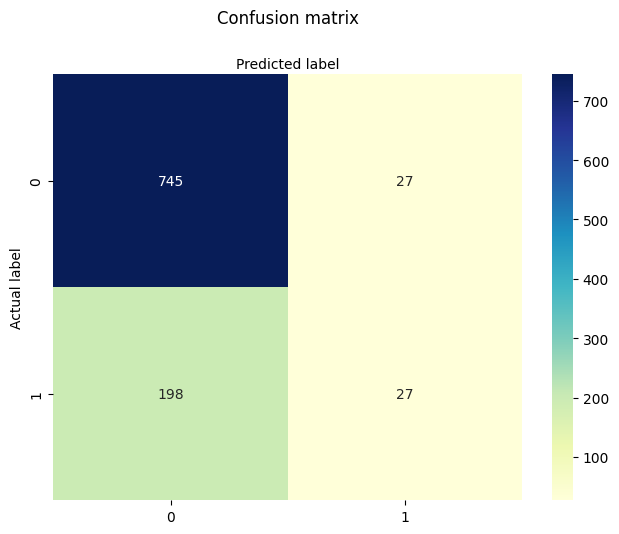

In [ ]:
from matplotlib.text import Text
class_names=[0,1]
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
sns.heatmap(pd.DataFrame(confusion_matrix(y_pred_lr,y_test)), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
Text(0.5,257.44,'Predicted label');

In [ ]:
#keep the probabilities for the positive predictions
y_pred_lr = lr.predict_proba(X_test)[:, 1]

# Calculate the true positive rate (TPR), false positive rate (FPR)
lr_fpr, lr_tpr, thresholds = roc_curve(y_test, y_pred_lr)

# Calculate the AUC score
auc_lr = roc_auc_score(y_test, y_pred_lr)
print("AUC score:", auc_lr)

AUC score: 0.754919288323318


AU_lr: 0.754919288323318


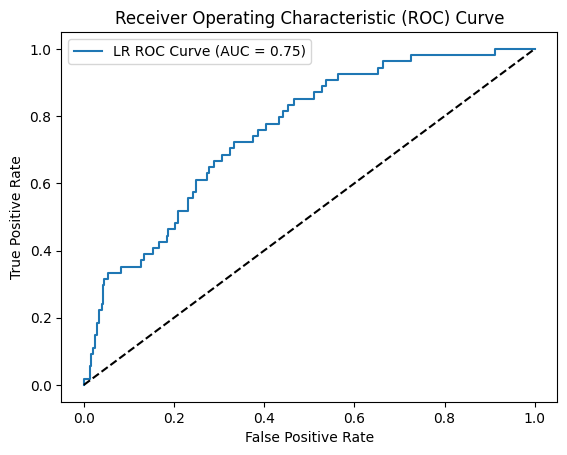

In [ ]:

print("AU_lr:", auc_lr)
# Plot the ROC curve
plt.plot(lr_fpr, lr_tpr, label='LR ROC Curve (AUC = {:.2f})'.format(auc_lr))
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random guessing
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

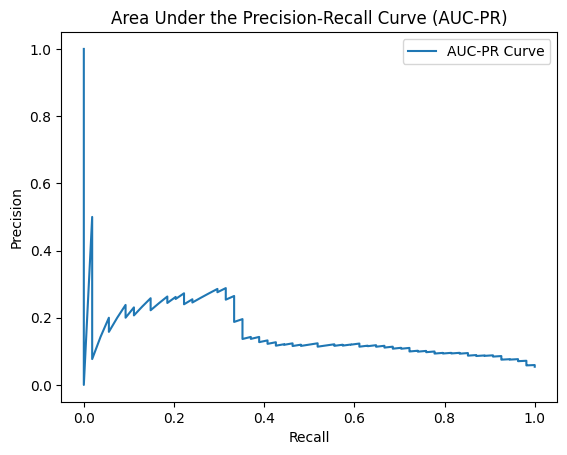

In [ ]:
# Plot AUC-PR curve
lr_precision, lr_recall, _ = precision_recall_curve(y_test, y_pred_lr)
plt.plot(lr_recall, lr_precision, label='AUC-PR Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Area Under the Precision-Recall Curve (AUC-PR)')
plt.legend()
plt.show()

Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier()
dt.fit(X_train_sm,y_train_sm)
y_pred_dt = dt.predict(X_test)

In [ ]:
score_dt = accuracy_score(y_test, y_pred_dt)
precision_dt = precision_score(y_test, y_pred_dt)
recall_dt = recall_score(y_test, y_pred_dt)
auc_dt = roc_auc_score(y_test, y_pred_dt)
fscore_dt = f1_score(y_test, y_pred_dt)
print('ROC AUC: ',auc_dt)
print(f'Classification Report for Decision Tree \n\n{classification_report(y_test, y_pred_dt)}')


ROC AUC:  0.5721201052590236
Classification Report for Decision Tree 

              precision    recall  f1-score   support

           0       0.95      0.90      0.93       943
           1       0.12      0.24      0.16        54

    accuracy                           0.87       997
   macro avg       0.54      0.57      0.55       997
weighted avg       0.91      0.87      0.89       997



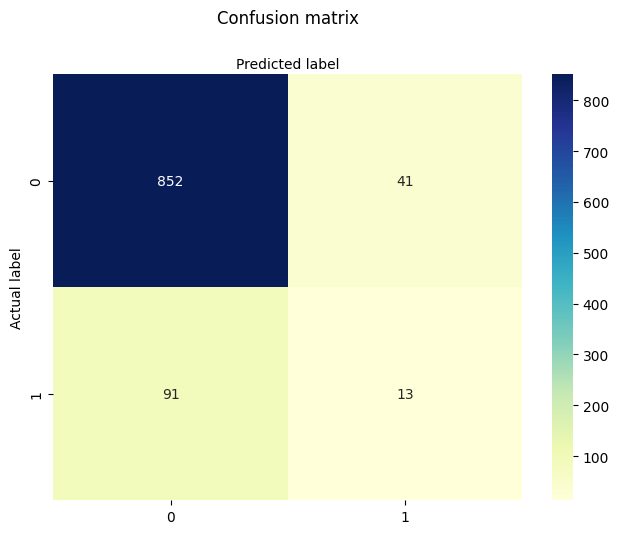

In [ ]:
from matplotlib.text import Text
class_names=[0,1]
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
sns.heatmap(pd.DataFrame(confusion_matrix(y_pred_dt,y_test)), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
Text(0.5,257.44,'Predicted label');

In [ ]:
# Calculate the true positive rate (TPR), false positive rate (FPR)
dt_fpr, dt_tpr, thresholds = roc_curve(y_test, y_pred_dt)

# Calculate the AUC score
auc_dt = roc_auc_score(y_test, y_pred_dt)
print("AUC score:", auc_dt)

AUC score: 0.5721201052590236


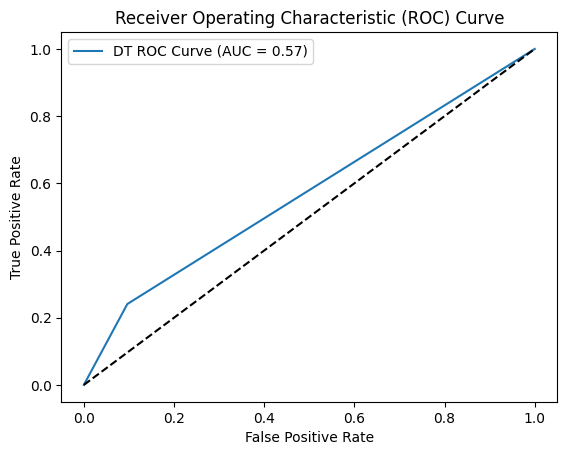

In [ ]:

# Plot the ROC curve
plt.plot(dt_fpr, dt_tpr, label='DT ROC Curve (AUC = {:.2f})'.format(auc_dt))
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random guessing
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

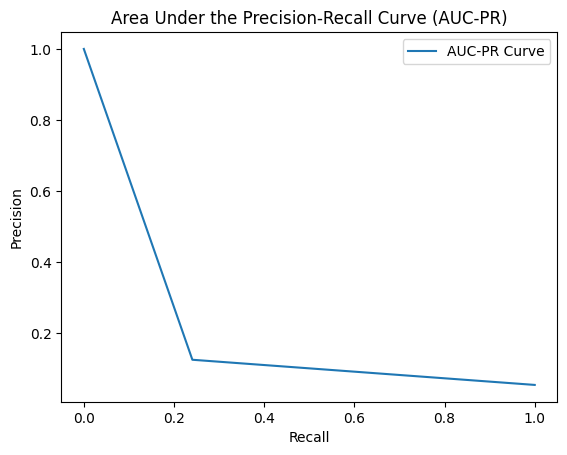

In [ ]:
# Plot AUC-PR curve
dt_precision, dt_recall, _ = precision_recall_curve(y_test, y_pred_dt)
plt.plot(dt_recall, dt_precision, label='AUC-PR Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Area Under the Precision-Recall Curve (AUC-PR)')
plt.legend()
plt.show()

# Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()
nb.fit(X_train_sm,y_train_sm)
y_pred_nb = nb.predict(X_test)

In [ ]:
from sklearn.metrics import roc_auc_score
score_nb = accuracy_score(y_pred_nb,y_test)
precision_nb = precision_score(y_test, y_pred_nb)
recall_nb = recall_score(y_test, y_pred_nb)
auc_nb = roc_auc_score(y_test, y_pred_nb)
fscore_nb = f1_score(y_test, y_pred_nb)
print(f'Classification Report for Naive Bayes \n\n{classification_report(y_test, y_pred_nb)}')

y_pred_nb_proba = nb.predict_proba(X_test)[:, 1]
nb_fpr, nb_tpr, thresholds = roc_curve(y_test, y_pred_nb_proba)

Classification Report for Naive Bayes 

              precision    recall  f1-score   support

           0       0.97      0.74      0.84       943
           1       0.12      0.61      0.20        54

    accuracy                           0.73       997
   macro avg       0.54      0.67      0.52       997
weighted avg       0.92      0.73      0.80       997



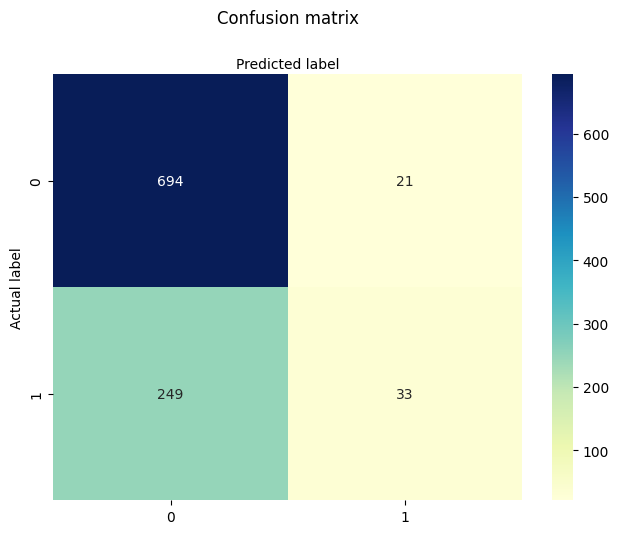

In [ ]:
from matplotlib.text import Text
class_names=[0,1]
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
sns.heatmap(pd.DataFrame(confusion_matrix(y_pred_nb,y_test)), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
Text(0.5,257.44,'Predicted label');

In [ ]:
#keep the probabilities for the positive predictions
y_pred_nb = nb.predict_proba(X_test)[:, 1]

# Calculate the true positive rate (TPR), false positive rate (FPR)
nb_fpr, nb_tpr, thresholds = roc_curve(y_test, y_pred_nb)

# Calculate the AUC score
auc_nb = roc_auc_score(y_test, y_pred_nb)
print("AUC score:", auc_nb)

AUC score: 0.7565099564039118


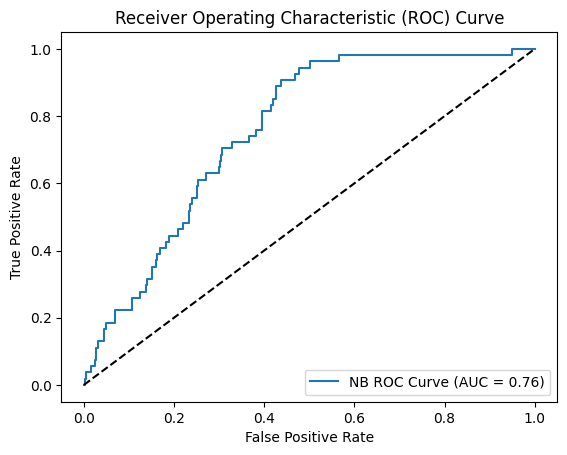

In [ ]:

# Plot the ROC curve
plt.plot(nb_fpr, nb_tpr, label='NB ROC Curve (AUC = {:.2f})'.format(auc_nb))
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random guessing
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

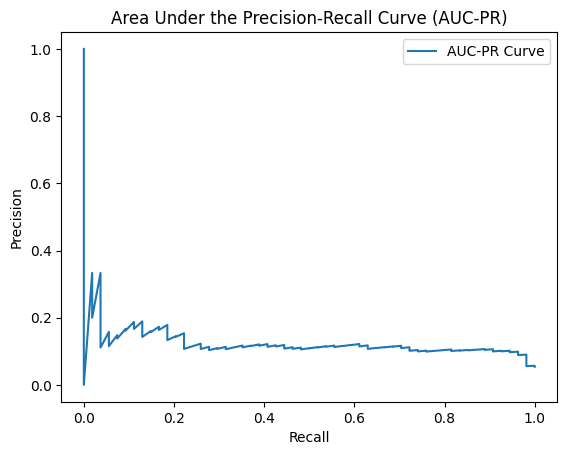

In [ ]:
# Plot AUC-PR curve
nb_precision, nb_recall, _ = precision_recall_curve(y_test, y_pred_nb)
plt.plot(nb_recall, nb_precision, label='AUC-PR Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Area Under the Precision-Recall Curve (AUC-PR)')
plt.legend()
plt.show()

K-Nearest Neighbors

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(X_train_sm,y_train_sm)
y_pred_knn=knn.predict(X_test)


In [ ]:
score_knn = accuracy_score(y_pred_knn,y_test)
fscore_knn = f1_score(y_pred_knn,y_test)
precision_knn = precision_score(y_pred_knn,y_test)
recall_knn = recall_score(y_pred_knn,y_test)
auc_knn = roc_auc_score(y_test, y_pred_knn)
print('Results for KNN Model')
print('ROC AUC:',auc_knn)
print(f'Classification Report for K nearest neighbors \n\n{classification_report(y_test, y_pred_knn)}')

y_pred_knn_proba = knn.predict_proba(X_test)[:, 1]
knn_fpr, knn_tpr, thresholds = roc_curve(y_test, y_pred_knn_proba)

Results for KNN Model
ROC AUC: 0.6601076155689094
Classification Report for K nearest neighbors 

              precision    recall  f1-score   support

           0       0.97      0.80      0.88       943
           1       0.13      0.52      0.21        54

    accuracy                           0.79       997
   macro avg       0.55      0.66      0.54       997
weighted avg       0.92      0.79      0.84       997



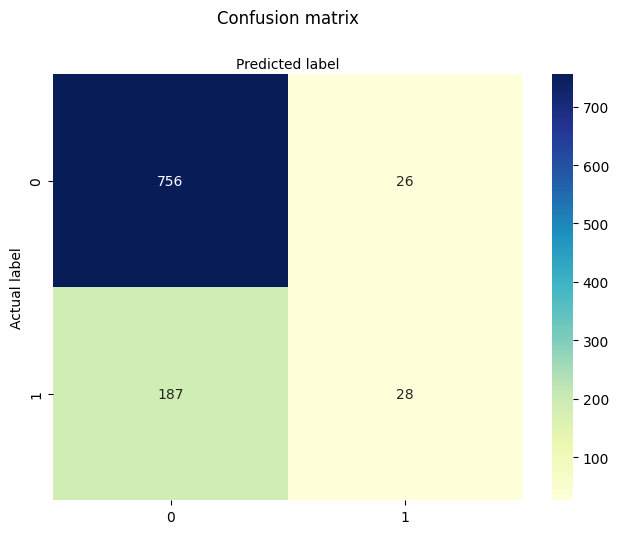

In [ ]:
from matplotlib.text import Text
class_names=[0,1]
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
sns.heatmap(pd.DataFrame(confusion_matrix(y_pred_knn,y_test)), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
Text(0.5,257.44,'Predicted label');

In [ ]:
#keep the probabilities for the positive predictions
y_pred_knn = knn.predict_proba(X_test)[:, 1]

# Calculate the true positive rate (TPR), false positive rate (FPR)
knn_fpr, knn_tpr, thresholds = roc_curve(y_test, y_pred_knn)

# Calculate the AUC score
auc_knn = roc_auc_score(y_test, y_pred_knn)
print("AUC score:", auc_knn)

AUC score: 0.7144161659007895


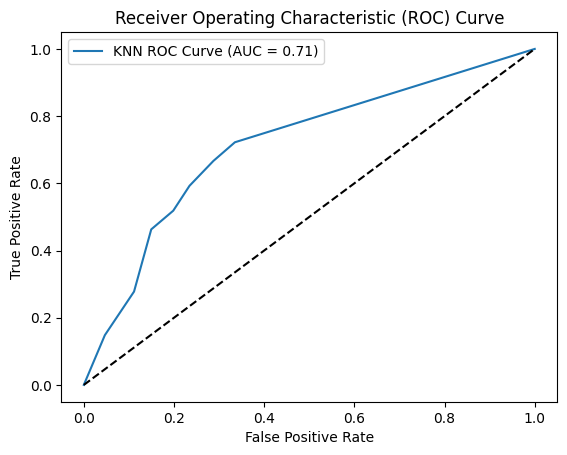

In [ ]:

# Plot the ROC curve
plt.plot(knn_fpr, knn_tpr, label='KNN ROC Curve (AUC = {:.2f})'.format(auc_knn))
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random guessing
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

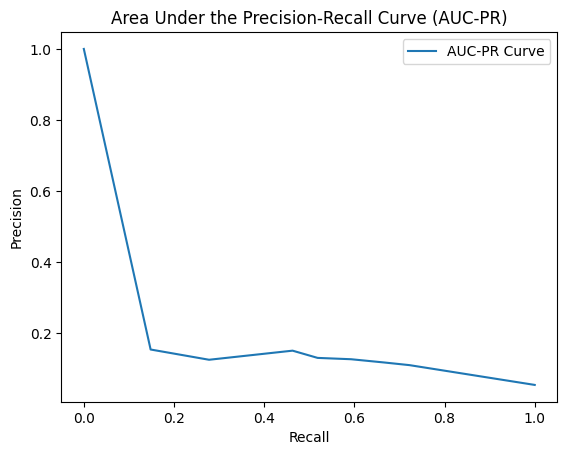

In [ ]:
# Plot AUC-PR curve
knn_precision, knn_recall, _ = precision_recall_curve(y_test, y_pred_knn)
plt.plot(knn_recall, knn_precision, label='AUC-PR Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Area Under the Precision-Recall Curve (AUC-PR)')
plt.legend()
plt.show()

SVM CLASSIFIER

In [ ]:
from sklearn import svm
sv = svm.SVC(kernel='linear')
sv.fit(X_train_sm, y_train_sm)
y_pred_svm = sv.predict(X_test)

In [ ]:
score_svm = accuracy_score(y_pred_svm,y_test)
fscore_svm = f1_score(y_pred_svm,y_test)
precision_svm = precision_score(y_pred_svm,y_test)
recall_svm = recall_score(y_pred_svm,y_test)
auc_svm = roc_auc_score(y_test, y_pred_svm)
print('Results for SVM Model')
print(f'Classification Report for Support Vector Machines \n\n{classification_report(y_test, y_pred_svm)}')

# Note: SVM with a linear kernel in scikit-learn does not directly provide predict_proba.
# For ROC curve, we can use decision_function to get a score, which is then used
# to calculate fpr, tpr, and thresholds.
svm_scores = sv.decision_function(X_test)
svm_fpr, svm_tpr, thresholds = roc_curve(y_test, svm_scores)

Results for SVM Model
Classification Report for Support Vector Machines 

              precision    recall  f1-score   support

           0       0.97      0.78      0.86       943
           1       0.12      0.52      0.19        54

    accuracy                           0.77       997
   macro avg       0.54      0.65      0.53       997
weighted avg       0.92      0.77      0.83       997



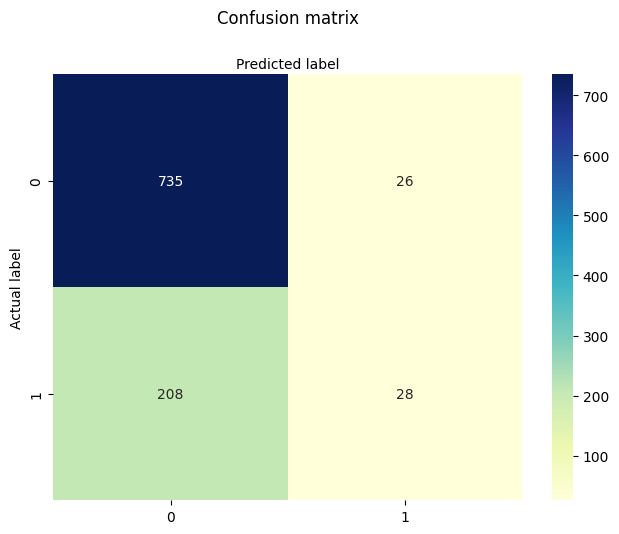

In [ ]:
from matplotlib.text import Text
class_names=[0,1]
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
sns.heatmap(pd.DataFrame(confusion_matrix(y_pred_svm,y_test)), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
Text(0.5,257.44,'Predicted label');

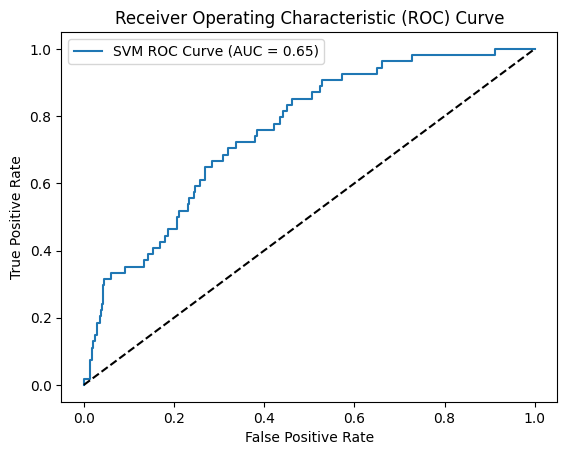

In [ ]:

# Plot the ROC curve
plt.plot(svm_fpr, svm_tpr, label='SVM ROC Curve (AUC = {:.2f})'.format(auc_svm))
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random guessing
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

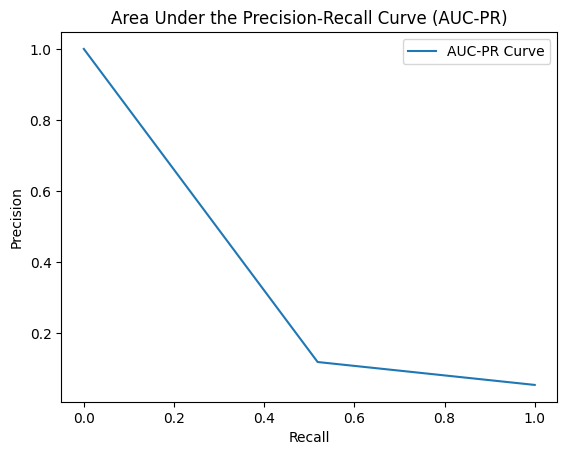

In [ ]:
# Plot AUC-PR curve
svm_precision, svm_recall, _ = precision_recall_curve(y_test, y_pred_svm)
plt.plot(svm_recall, svm_precision, label='AUC-PR Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Area Under the Precision-Recall Curve (AUC-PR)')
plt.legend()
plt.show()

COMPARING THE EVALUATIONS OF INTERPRETABLE MODELS TRAINED AND TESTED ON THE SAME DATA WITH A BLACK BOX MODEL.

In [ ]:
auc = [auc_lr,auc_nb,auc_svm,auc_knn,auc_dt]
scores = [score_lr,score_nb,score_svm,score_knn,score_dt]
precision = [precision_lr,precision_nb,precision_svm,precision_knn,precision_dt]
recall = [recall_lr,recall_nb,recall_svm,recall_knn,recall_dt]
fscore = [fscore_lr,fscore_nb,fscore_svm,fscore_knn,fscore_dt]
names = ["LR", "NB", "SVM", "KNN", "DT"]
classification_results = pd.DataFrame({
    "Accuracy": scores,
    "Precision": precision,
    "Recall":recall,
    "F1 Score":fscore,
    "AUC":auc
})
classification_results.index = names
classification_results

,Accuracy,Precision,Recall,F1 Score,AUC
LR,0.774323,0.120000,0.500000,0.193548,0.754919
NB,0.729188,0.117021,0.611111,0.196429,0.673530
SVM,0.765296,0.518519,0.118644,0.193103,0.648973
KNN,0.786359,0.518519,0.130233,0.208178,0.714416
DT,0.867603,0.125000,0.240741,0.164557,0.572120


Text(0.5, 1.0, 'Final scaled output results for machine learning models')

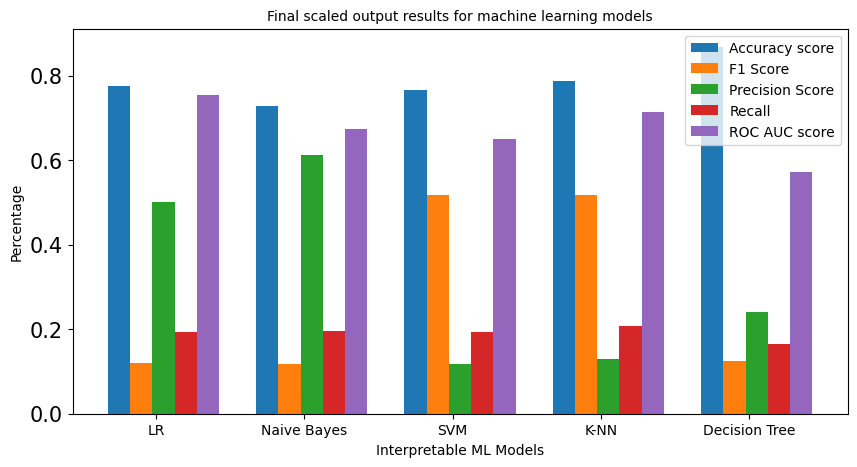

In [ ]:
algorithms = np.arange(len(names))
plt.figure(figsize = (10, 5))
plt.yticks(fontsize = 15)
plt.bar(algorithms, [i for i in scores], width = 0.15)
plt.bar(algorithms + 0.15, [i for i in precision], width = 0.15)
plt.bar(algorithms + 0.15 * 2, [i for i in recall], width = 0.15)
plt.bar(algorithms + 0.15 * 3, [i for i in fscore], width = 0.15)
plt.bar(algorithms + 0.15 * 4, [i for i in auc], width = 0.15)
plt.legend(['Accuracy score', 'F1 Score', 'Precision Score', 'Recall', 'ROC AUC score'], fontsize = 10)
plt.xticks([i + 0.25 for i in range(5)], ["LR","Naive Bayes","SVM","K-NN","Decision Tree"], fontsize = 10)
plt.xlabel('Interpretable ML Models', fontsize = 10)
plt.ylabel('Percentage', fontsize = 10)
plt.title('Final scaled output results for machine learning models', fontsize = 10)

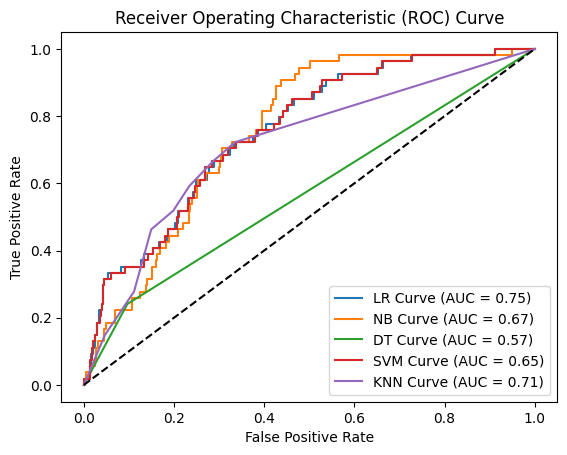

In [ ]:


# Plot the ROC curve
plt.plot(lr_fpr, lr_tpr, label='LR Curve (AUC = {:.2f})'.format(auc_lr))
plt.plot(nb_fpr, nb_tpr, label='NB Curve (AUC = {:.2f})'.format(auc_nb))
plt.plot(dt_fpr, dt_tpr, label='DT Curve (AUC = {:.2f})'.format(auc_dt))
plt.plot(svm_fpr, svm_tpr, label='SVM Curve (AUC = {:.2f})'.format(auc_svm))
plt.plot(knn_fpr, knn_tpr, label='KNN Curve (AUC = {:.2f})'.format(auc_knn))
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random guessing
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

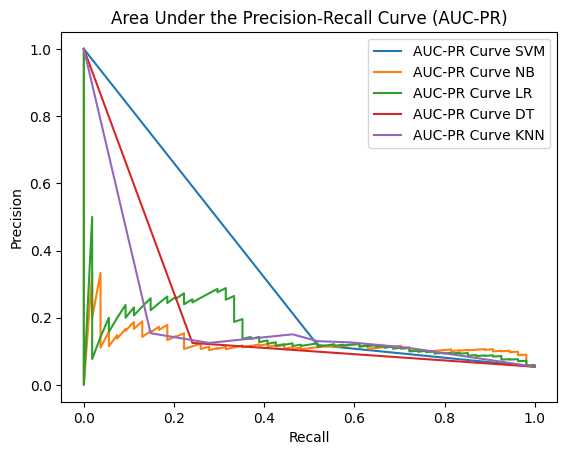

In [ ]:
# Plot AUC-PR curve
svm_precision, svm_recall, _ = precision_recall_curve(y_test, y_pred_svm)
plt.plot(svm_recall, svm_precision, label='AUC-PR Curve SVM')
plt.plot(nb_recall, nb_precision, label='AUC-PR Curve NB')
plt.plot(lr_recall, lr_precision, label='AUC-PR Curve LR')
plt.plot(dt_recall, dt_precision, label='AUC-PR Curve DT')
plt.plot(knn_recall, knn_precision, label='AUC-PR Curve KNN')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Area Under the Precision-Recall Curve (AUC-PR)')
plt.legend()
plt.show()